In [75]:
from datasets import load_dataset
import numpy as np
from transformers import ASTFeatureExtractor
import torch
from transformers import ASTConfig, ASTModel
from PIL import Image
import requests
import seaborn as sns
from matplotlib import pyplot as plt

from transformers import CLIPProcessor, CLIPModel


In [76]:
dataset = load_dataset("DavidVivancos/MindBigData2022_MNIST_IN")


  0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
sorted(set(map(lambda x: x.split("-")[0], dataset["train"][0].keys())) - {'label'})


['AF3', 'AF4', 'PZ', 'T7', 'T8']

In [78]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

urls = [
  "http://images.cocodataset.org/val2017/000000039769.jpg",
  "https://farm3.staticflickr.com/2674/5850229113_4fe05d5265_z.jpg",
]
images = [Image.open(requests.get(url, stream=True).raw) for url in urls]

texts = ["cat", "dog"]
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs, return_loss=True)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities


<Axes: >

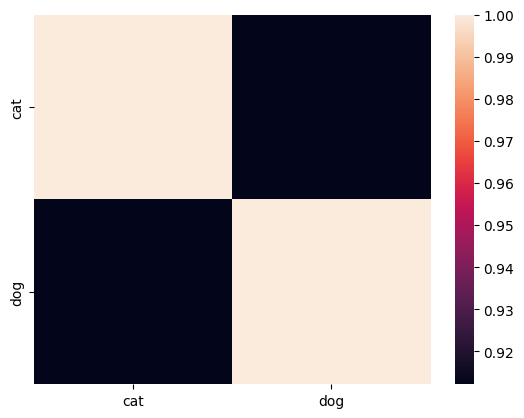

In [79]:

confusion_matrix = outputs.text_embeds @ outputs.text_embeds.T
confusion_matrix = confusion_matrix.detach().cpu().numpy()
sns.heatmap(confusion_matrix, xticklabels=texts, yticklabels=texts)


In [80]:
channels = set()
def convert(item):
  item2 = {
    "label": item["label"],
  }
  for k, v in item.items():
    if k == "label":
      continue
    channel = k.split("-")[0]
    if channel not in item2:
      item2[channel] = []
      channels.add(channel)
    item2[channel].append(v)
  for channel in channels:
    item2[channel] = np.array(item2[channel])
  return item2


In [81]:

# Initializing a AST MIT/ast-finetuned-audioset-10-10-0.4593 style configuration
configuration = ASTConfig()

# Initializing a model (with random weights) from the MIT/ast-finetuned-audioset-10-10-0.4593 style configuration
model = ASTModel(configuration)

# Accessing the model configuration
configuration = model.config


In [82]:
sample_tensor = convert(dataset["train"][0])


In [83]:

means = {}
stds = {}
feature_extractors = {}
for channel in channels:
  means[channel] = np.array(sample_tensor[channel]).mean()
  stds[channel] = np.array(sample_tensor[channel]).std()
  feature_extractors[channel] = ASTFeatureExtractor(
    sampling_rate=128,
    num_mel_bins=128,
    max_length=256,
  )


In [84]:
def preprocess(inputs):
  outputs = {}
  outputs["label"] = inputs["label"]
  features = []
  for channel in channels:
    features.append(feature_extractors[channel](inputs[channel], sampling_rate=128, return_tensors="pt")['input_values'])
  outputs["pixel_values"] = torch.stack(features, 1)
  return outputs


In [85]:
pixel_values = preprocess(sample_tensor)["pixel_values"]
# batch_size, num_channels, height, width)


In [86]:
import librosa


In [87]:
array, sampling_rate = librosa.load(librosa.ex("trumpet"))


<Axes: >

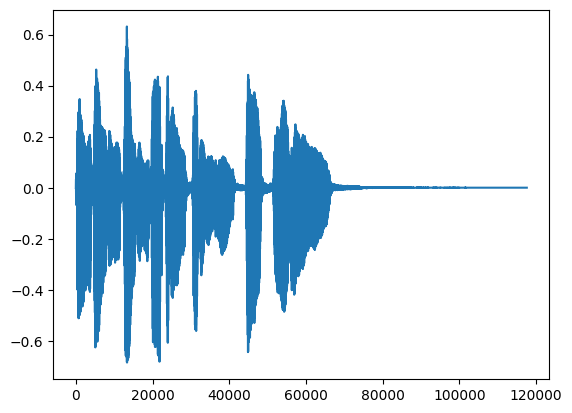

In [88]:
sns.lineplot(data=array)


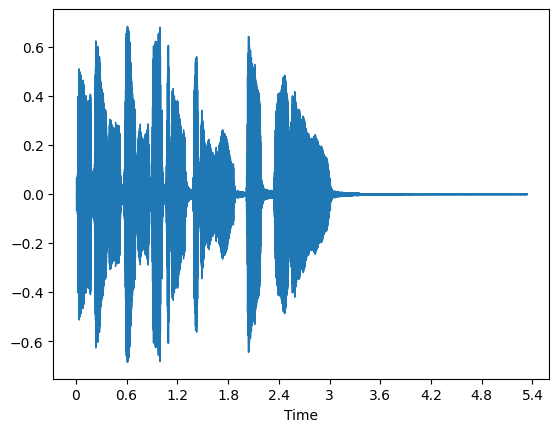

In [89]:
librosa.display.waveshow(array, sr=sampling_rate)


In [90]:
standardized_sample = (sample_tensor["T7"] - means["T7"]) / stds["T7"]


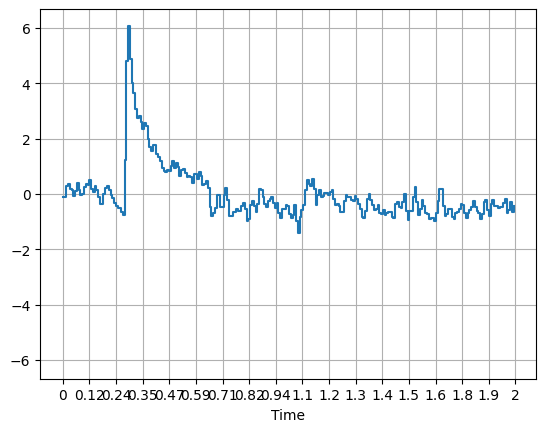

In [91]:
librosa.display.waveshow(standardized_sample, sr=128)
# gridlines
# set x ticks 0.1
plt.xticks(np.arange(0, 2.1, 2 / 17))
plt.grid(True)


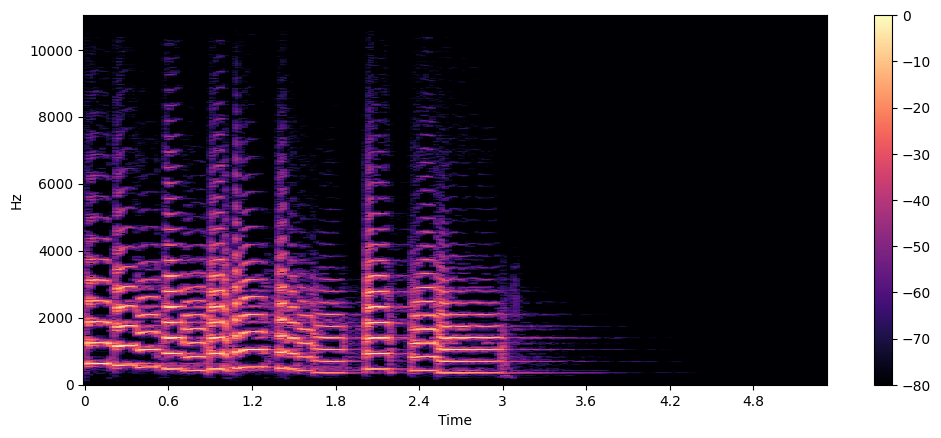

In [92]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()


(24, 24) 576


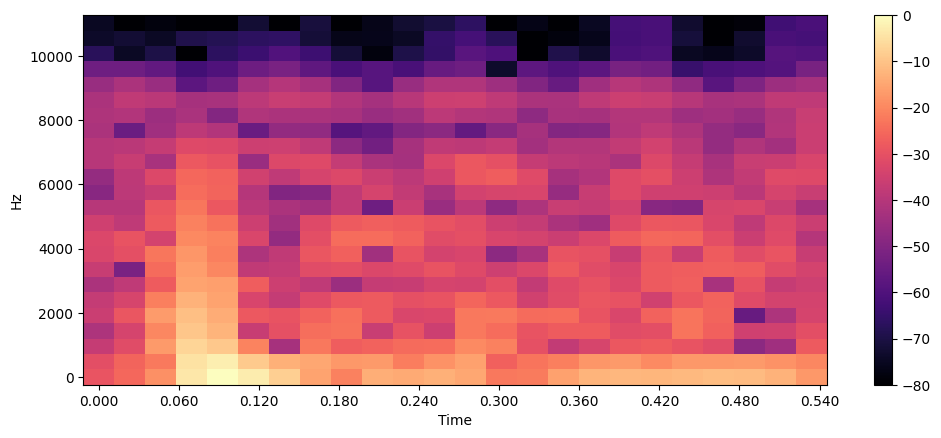

In [93]:
n_fft = 46
D = librosa.stft(standardized_sample, n_fft=n_fft)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
print(S_db.shape, S_db.size)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", fmax=100)
plt.colorbar()


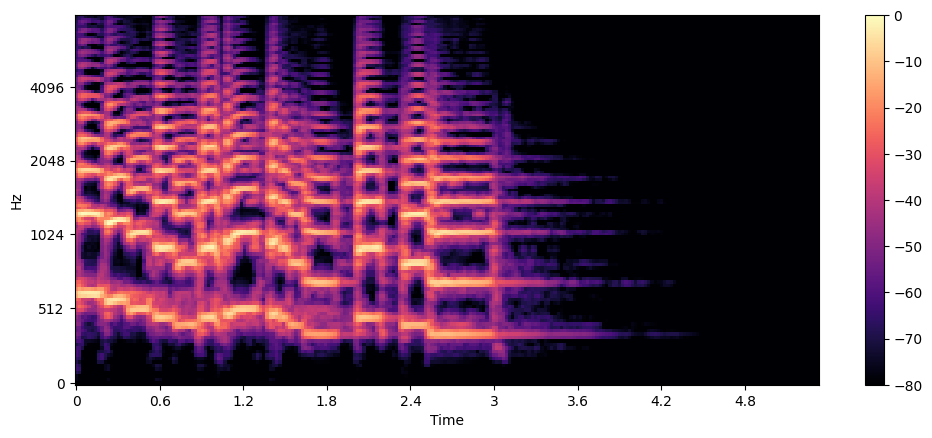

In [98]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", fmax=8000)
plt.colorbar()


(128, 257) 32896


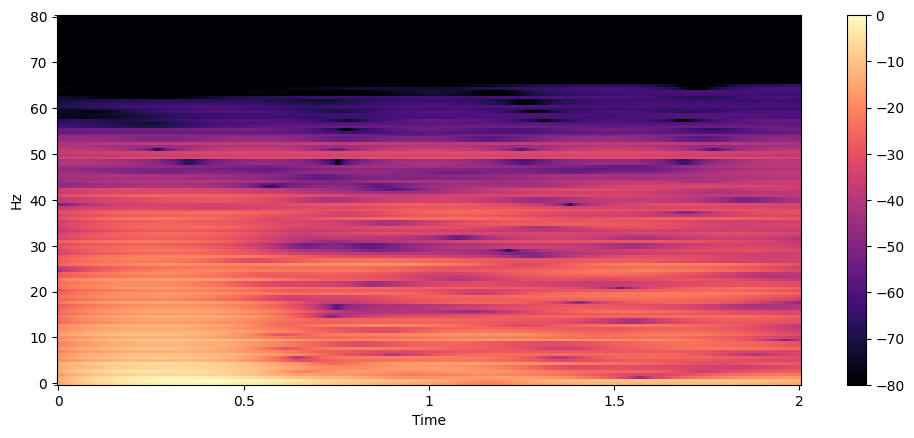

In [124]:
melspectrogram_kwargs = {
    "n_fft": 128,
    "hop_length": 1,
    "fmax": 80,
    "sr": 128,
    "n_mels": 128,
}
S = librosa.feature.melspectrogram(y=standardized_sample, **melspectrogram_kwargs)
S = librosa.power_to_db(S, ref=np.max)
print(S.shape, S.size)

plt.figure().set_figwidth(12)
del melspectrogram_kwargs["n_mels"]
librosa.display.specshow(S, x_axis="time", y_axis="mel", **melspectrogram_kwargs)
plt.colorbar()
plt.yticks(np.arange(0, melspectrogram_kwargs["fmax"] + 1, 10))
plt.show()


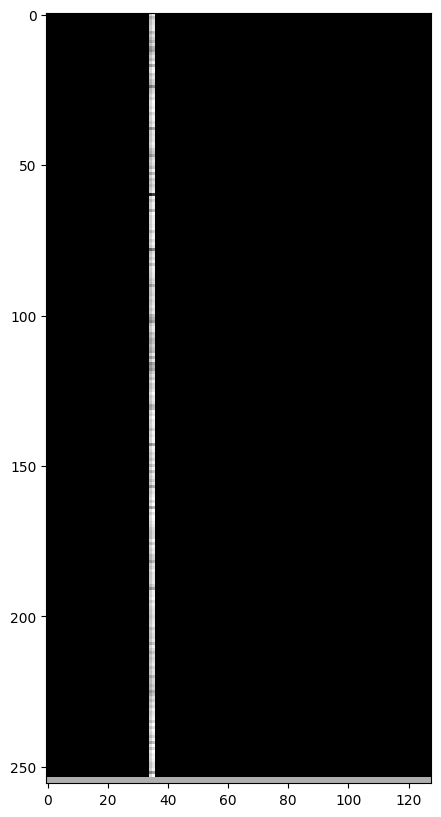

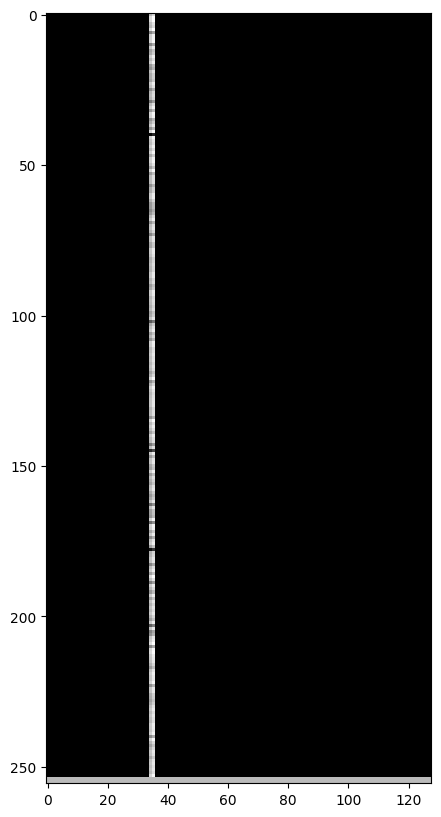

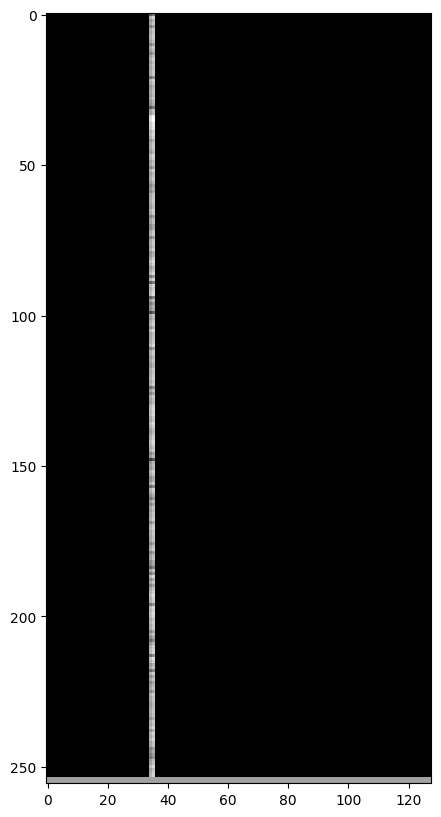

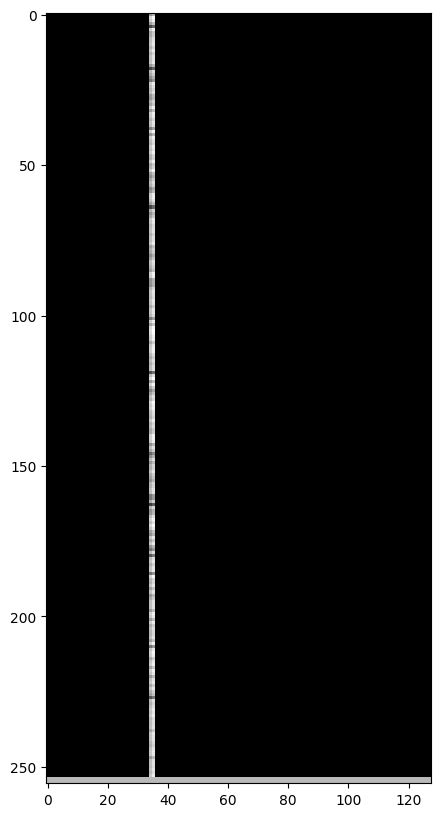

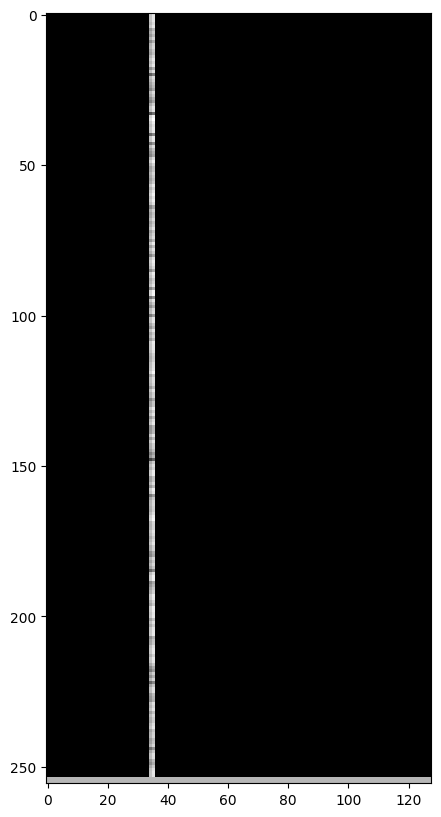

In [96]:
import matplotlib.pyplot as plt
for channel in range(pixel_values.shape[1]):
  plt.figure(figsize=(10, 10))
  plt.imshow(pixel_values[0, channel].numpy(), cmap="gray")
  plt.show()
